In [1]:
import sys, os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"


import tensorflow as tf
import sys
sys.path.append("..")
import tools
import matplotlib.pyplot as plt
from astroML.crossmatch import crossmatch_angular
import numpy as np
from lsst.daf.butler import Butler
import pandas as pd
import multiprocessing
import os
%load_ext autoreload
%autoreload 2

2024-05-08 01:37:13.654412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 01:37:13.654486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 01:37:13.729273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 01:37:13.773114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 01:37:20.250698: W tensorflow/compiler/tf2

In [2]:
!nvidia-smi

Wed May  8 01:38:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:21:00.0 Off |                  N/A |
| 26%   33C    P8              15W / 260W |     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
def create_NN_prediction (dataset_path, model_path="../DATA/Trained_model", threshold=0.5):
    dataset_test = tf.data.TFRecordDataset([dataset_path])
    tfrecord_shape = tools.model.get_shape_of_quadratic_image_tfrecord(dataset_test)
    dataset_test = dataset_test.map(tools.model.parse_function(img_shape=tfrecord_shape, test=True))
    dataset_test = dataset_test.batch(1024)
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = tf.keras.models.load_model(model_path , compile=False)
        predictions = model.predict(dataset_test)
    p = predictions>0.5
    predictions = tools.data.npy_merge(predictions>threshold, (4176, 2048))
    return predictions

def one_hit (p, injected_calexp, catalog_row, i):
    origin = injected_calexp.getWcs().skyToPixelArray(np.array([catalog_row["ra"]]), np.array([catalog_row["dec"]]),
                                                 degrees=True)
    angle = catalog_row["beta"]
    length = catalog_row["trail_length"]
    mask = np.zeros(injected_calexp.image.array.shape)
    mask = tools.data.draw_one_line(mask, origin, angle, length, line_thickness=6)
    return {'injection_id': catalog_row['injection_id'], 'ra' : catalog_row['ra'], 'dec' : catalog_row['dec'],
                    'trail_length' : catalog_row['trail_length'],'beta' : catalog_row['beta'],
                    'mag' : catalog_row['mag'], 'n' : i, 'x' : round(origin[0][0]), 'y' : round(origin[1][0]), 
                    'detected' : int(((mask==1) & (p==1)).sum()>0)}
    
def compare_NN_predictions (p, repo, output_coll, val_index = None, batch_size=None):
    butler = Butler(repo)
    catalog_ref = list(butler.registry.queryDatasets("injected_postISRCCD_catalog",
                                                     collections=output_coll,
                                                     instrument='HSC'))
    ref = list(butler.registry.queryDatasets("injected_calexp",
                                             collections=output_coll,
                                            instrument='HSC'))
    parameters = []
    if batch_size is None:
        batch_size = os.cpu_count() - 1
    if val_index is None:
        val_index = list (range(len(catalog_ref)))
    for i, index in enumerate(val_index):
        injected_calexp = butler.get("injected_calexp",
                                     dataId=ref[index].dataId,
                                     collections=output_coll)
        catalog = butler.get("injected_postISRCCD_catalog",
                             dataId=catalog_ref[index].dataId,
                             collections=output_coll)
        catalog[catalog["injection_flag"]==0]
        parameters += [(p[i], injected_calexp, k, i) for k in catalog]
    print ("Conuting hits")
    pool = multiprocessing.Pool(batch_size)
    list_cat = pool.starmap(one_hit, parameters)
    pool.close()
    pool.join()
    print ("Done")
    return pd.DataFrame(list_cat)

def NN_comparation_histogram_data (model_path, tf_dataset_path, val_index_path, repo, output_coll, 
                                   column_name="trail_length", batch_size=None, threshold=0.5):
    print ("NN predicting")
    predictions = create_NN_prediction (tf_dataset_path, model_path, threshold=threshold)
    with open(val_index_path, 'rb') as f:
        val_index = np.load(f)
        val_index.sort()
    print ("Comparing to true catalog")
    cat = compare_NN_predictions (predictions, repo, output_coll, val_index = val_index, batch_size=batch_size)
    print ("Done!")
    return cat[cat["detected"]==1][column_name].to_numpy(), cat[column_name].to_numpy()

In [4]:
def one_LSST_stack_comparison (butler, output_coll, injection_catalog_id, source_catalog_id, calexp_id, 
                               column_name):
        injection_catalog= butler.get("injected_postISRCCD_catalog", 
                                      dataId=injection_catalog_id.dataId, 
                                      collections=output_coll,)
        injection_catalog[injection_catalog["injection_flag"]==0]
        original_source_catalog= butler.get("src", 
                                   dataId=source_catalog_id.dataId, 
                                   collections=output_coll,)
        source_catalog= butler.get("injected_src", 
                                   dataId=source_catalog_id.dataId, 
                                   collections=output_coll,)
        calexp = butler.get("injected_calexp", 
                            dataId=calexp_id.dataId, 
                            collections=output_coll)
        sc = source_catalog.asAstropy().to_pandas()
        osc = original_source_catalog.asAstropy().to_pandas()
        dist, ind = crossmatch_angular(sc[['coord_ra', 'coord_dec']].values, 
                                           osc[['coord_ra', 'coord_dec']].values, 0.04 / 3600)
        source_origin = calexp.getWcs().skyToPixelArray(np.array([source_catalog["coord_ra"][np.isinf(dist)]]), 
                                                        np.array([source_catalog["coord_dec"][np.isinf(dist)]]),
                                                        degrees=False)
        injected_origin = calexp.getWcs().skyToPixelArray(np.array([injection_catalog["ra"]]), 
                                                          np.array([injection_catalog["dec"]]),
                                                          degrees=True)
        angle = injection_catalog["beta"]
        length = injection_catalog["trail_length"]
        mask_source = np.zeros(calexp.image.array.shape)
        mask_source [source_origin[1].astype(int),source_origin[0].astype(int)] = 1
        matched_values = np.array([])
        for j in range (len (angle)):
            mask_inject = tools.data.draw_one_line(np.zeros(calexp.image.array.shape), 
                                                    (injected_origin[0][j], injected_origin[1][j]),
                                                    angle[j], length[j])
            if (mask_inject*mask_source).sum()>0:
                matched_values = np.append(matched_values, injection_catalog[column_name][j])
        return matched_values
            
    

def LSST_stack_comparation_histogram_data(repo, output_coll, val_index_path, 
                                          column_name="trail_length", batch_size=None):
    with open(val_index_path, 'rb') as f:
        val_index = np.load(f)
        val_index.sort()
    butler = Butler(repo)
    injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=output_coll, instrument='HSC'))
    source_catalog_ids = list(butler.registry.queryDatasets("injected_src", collections=output_coll, instrument='HSC'))
    calexp_ids = list(butler.registry.queryDatasets("injected_calexp", collections=output_coll, instrument='HSC'))
    parameters = [(butler, output_coll, 
                    injection_catalog_ids[i], source_catalog_ids[i], 
                    calexp_ids[i], column_name) for i in val_index]
    if batch_size is None:
        batch_size = os.cpu_count() - 1
    print ("LSST stack comparison")
    pool = multiprocessing.Pool(batch_size)
    list_cat = pool.starmap(one_LSST_stack_comparison, parameters)
    pool.close()
    pool.join()
    print ("Done!")
    return np.concatenate(list_cat)

In [5]:
def get_magnitude_bin (repo, output_coll):
    butler = Butler(repo)
    injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=output_coll, instrument='HSC'))
    min_mag = 100
    max_mag = 0
    for injection_catalog_id in injection_catalog_ids:
        injection_catalog= butler.get("injected_postISRCCD_catalog", 
                                      dataId=injection_catalog_id.dataId, 
                                      collections=output_coll,)
        magnitudes = injection_catalog["mag"]
        min_mag = min (min_mag, injection_catalog["mag"].min())
        max_mag = max (max_mag, injection_catalog["mag"].max())
    return min_mag, max_mag
    

def plot_trail_histogram (NN_data, LSST_data, true_data=None):
    fig, ax = plt.subplots()
    bins = np.arange(4, 74, 5)
    if true_data is not None:
        ax.hist(true_data, bins=bins, histtype="step", label="True asteroids")
    ax.hist(NN_data, bins=bins, histtype="step", label="NN detected asteroids")
    ax.hist(LSST_data, bins=bins, histtype="step", label="LSST stack detected asteroids")
    ax.set_xlabel("Trail length")
    ax.set_ylabel("Count")
    ax.legend()
    return fig

def plot_magnitude_histogram (NN_data, LSST_data, true_data=None):
    fig, ax = plt.subplots()
    bins=np.arange(20,25.5,0.5)
    if true_data is not None:
        ax.hist(true_data, bins=bins, histtype="step", label="True asteroids")
    ax.hist(NN_data, bins=bins, histtype="step", label="NN detected asteroids")
    ax.hist(LSST_data, bins=bins, histtype="step", label="LSST stack detected asteroids")
    ax.set_xlabel("Magnitude")
    ax.set_ylabel("Count")
    ax.legend()
    return fig

In [6]:
model = "../DATA/Trained_model2"
threshold = 0.5

NN predicting


2024-05-07 13:13:40.558934: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2024-05-07 13:13:45.060048: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


30/30 [==============================] - 166s 5s/step
Comparing to true catalog
Done
Done!
LSST stack comparison
Done!


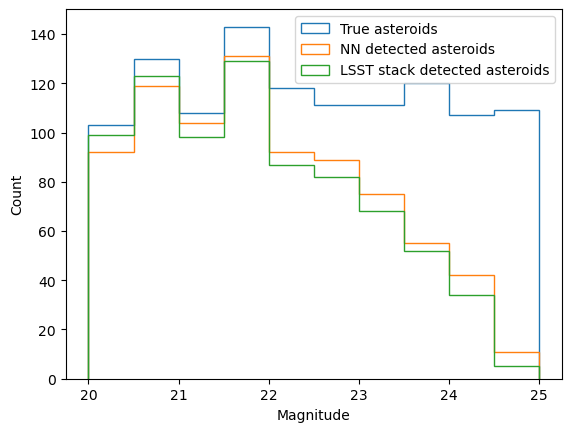

In [6]:
tfrecord_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/test1.tfrecord"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
collection = "u/kmrakovc/single_frame_injection_01"
NN_detected_asteroids_0, true_asteroids_0 = NN_comparation_histogram_data (model,
                                                                           tfrecord_path,
                                                                           val_index_path,
                                                                           repo_path,
                                                                           collection,
                                                                          column_name="mag",
                                                                          batch_size=10)
LSST_stack_detected_asteroids_0= LSST_stack_comparation_histogram_data(repo_path, 
                                                                       collection, 
                                                                       val_index_path,
                                                                      column_name="mag",
                                                                      batch_size=10)
fig_0 = plot_magnitude_histogram (NN_detected_asteroids_0, LSST_stack_detected_asteroids_0, true_asteroids_0)

NN predicting


2024-05-08 01:39:21.461201: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 01:39:21.461646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 01:39:25.276757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

2024-05-08 01:39:34.722534: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-08 01:39:34.740874: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-08 01:39:45.978863: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-08 01:39:46.003355: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_1_bfc) ran out of memory trying to allocate 7.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-08 01:39:46.143031: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 

30/30 [==============================] - 52s 972ms/step


2024-05-08 01:40:20.099507: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5440798351750389849
2024-05-08 01:40:20.099568: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13295634291604411972
2024-05-08 01:40:20.099624: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3398532942605058402
2024-05-08 01:40:20.099643: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12058453938479439445
2024-05-08 01:40:20.099662: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9707298447419826978
2024-05-08 01:40:20.099679: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2730130789245911573
2024-05-08 01:40:20.099695: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

Comparing to true catalog
Conuting hits
Done
Done!
LSST stack comparison
Done!


Text(0.5, 0.98, 'Magnitude: 20.0 - 25.0')

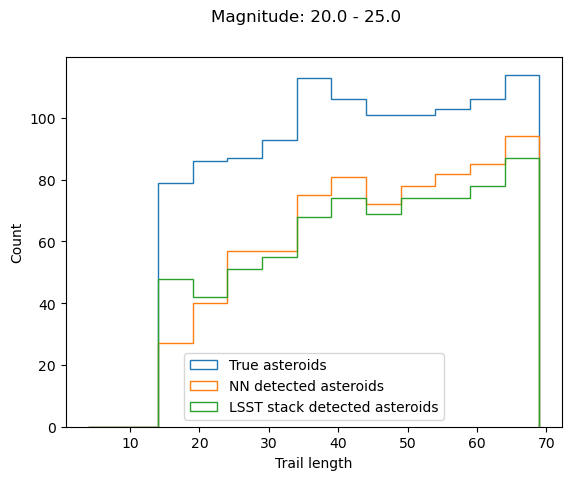

In [7]:
tfrecord_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/test1.tfrecord"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
collection = "u/kmrakovc/single_frame_injection_01"
NN_detected_asteroids_0, true_asteroids_0 = NN_comparation_histogram_data (model,
                                                                           tfrecord_path,
                                                                           val_index_path,
                                                                           repo_path,
                                                                           collection,
                                                                          batch_size=10)
LSST_stack_detected_asteroids_0= LSST_stack_comparation_histogram_data(repo_path, 
                                                                       collection, 
                                                                       val_index_path,
                                                                      batch_size=10)
fig_0 = plot_trail_histogram (NN_detected_asteroids_0, LSST_stack_detected_asteroids_0, true_asteroids_0)
minmag, maxmag = get_magnitude_bin (repo_path, collection)
fig_0.suptitle("Magnitude: "+str(round(minmag, 1))+" - "+str(round(maxmag, 1)))

NN predicting
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
30/30 [==============================] - 23s 728ms/step


2024-05-08 01:42:46.818182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5440798351750389849
2024-05-08 01:42:46.818235: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13295634291604411972
2024-05-08 01:42:46.818285: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12058453938479439445
2024-05-08 01:42:46.818300: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2730130789245911573
2024-05-08 01:42:46.818312: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11531490286931417162
2024-05-08 01:42:46.818326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11534941738753797482
2024-05-08 01:42:46.818339: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

Comparing to true catalog
Conuting hits
Done
Done!
LSST stack comparison
Done!


Text(0.5, 0.98, 'Magnitude: 24.0 - 24.5')

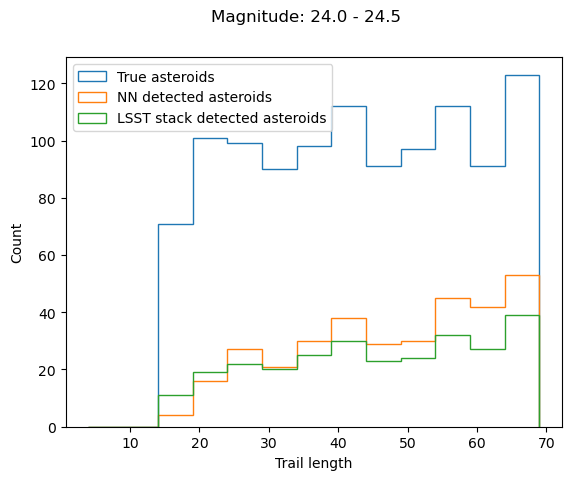

In [8]:
tfrecord_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/test2.tfrecord"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
collection = "u/kmrakovc/single_frame_injection_02"
NN_detected_asteroids_0, true_asteroids_0 = NN_comparation_histogram_data (model,
                                                                           tfrecord_path,
                                                                           val_index_path,
                                                                           repo_path,
                                                                           collection,
                                                                          batch_size=10)
LSST_stack_detected_asteroids_0= LSST_stack_comparation_histogram_data(repo_path, 
                                                                       collection, 
                                                                       val_index_path,
                                                                       batch_size=10)
fig_0 = plot_trail_histogram (NN_detected_asteroids_0, LSST_stack_detected_asteroids_0, true_asteroids_0)
minmag, maxmag = get_magnitude_bin (repo_path, collection)
fig_0.suptitle("Magnitude: "+str(round(minmag, 1))+" - "+str(round(maxmag, 1)))

NN predicting
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
30/30 [==============================] - 23s 738ms/step


2024-05-08 01:44:39.810423: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5440798351750389849
2024-05-08 01:44:39.810517: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3398532942605058402
2024-05-08 01:44:39.810532: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13295634291604411972
2024-05-08 01:44:39.810587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9707298447419826978
2024-05-08 01:44:39.810605: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12058453938479439445
2024-05-08 01:44:39.810622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2730130789245911573
2024-05-08 01:44:39.810634: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

Comparing to true catalog
Conuting hits
Done
Done!
LSST stack comparison
Done!


Text(0.5, 0.98, 'Magnitude: 24.5 - 25.0')

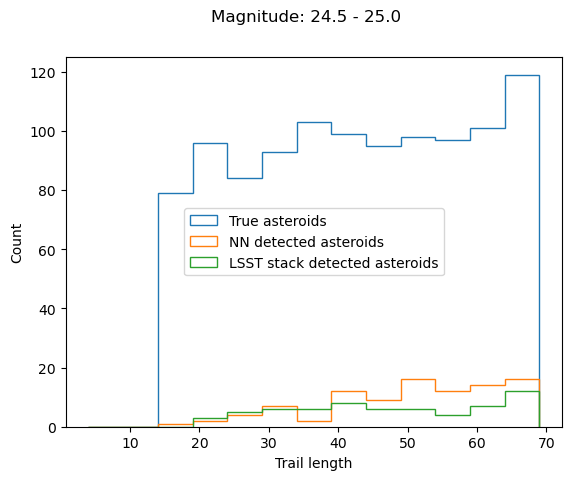

In [9]:
tfrecord_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/test3.tfrecord"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
collection = "u/kmrakovc/single_frame_injection_03"
NN_detected_asteroids_0, true_asteroids_0 = NN_comparation_histogram_data (model,
                                                                           tfrecord_path,
                                                                           val_index_path,
                                                                           repo_path,
                                                                           collection,
                                                                          batch_size=10)
LSST_stack_detected_asteroids_0= LSST_stack_comparation_histogram_data(repo_path, 
                                                                       collection, 
                                                                       val_index_path,
                                                                      batch_size=10)
fig_0 = plot_trail_histogram (NN_detected_asteroids_0, LSST_stack_detected_asteroids_0, true_asteroids_0)
minmag, maxmag = get_magnitude_bin (repo_path, collection)
fig_0.suptitle("Magnitude: "+str(round(minmag, 1))+" - "+str(round(maxmag, 1)))

NN predicting
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
30/30 [==============================] - 23s 732ms/step


2024-05-08 01:46:30.911596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5440798351750389849
2024-05-08 01:46:30.911644: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3398532942605058402
2024-05-08 01:46:30.911659: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9707298447419826978
2024-05-08 01:46:30.911672: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13295634291604411972
2024-05-08 01:46:30.911711: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12058453938479439445
2024-05-08 01:46:30.911727: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7567748983601318340
2024-05-08 01:46:30.911744: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

Comparing to true catalog
Conuting hits
Done
Done!
LSST stack comparison
Done!


Text(0.5, 0.98, 'Magnitude: 25.0 - 25.5')

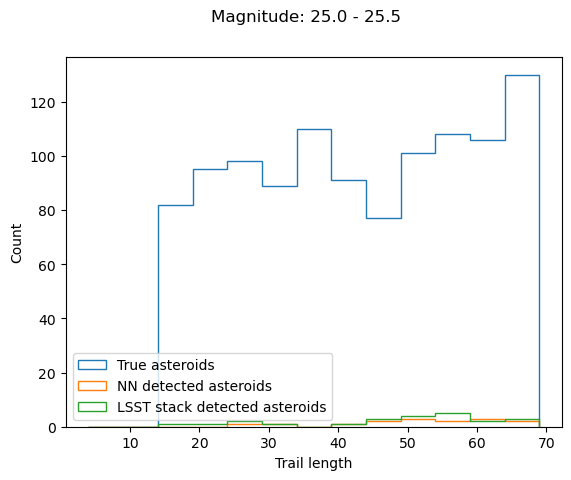

In [10]:
tfrecord_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/test4.tfrecord"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
collection = "u/kmrakovc/single_frame_injection_04"
NN_detected_asteroids_0, true_asteroids_0 = NN_comparation_histogram_data (model,
                                                                           tfrecord_path,
                                                                           val_index_path,
                                                                           repo_path,
                                                                           collection,
                                                                          batch_size=10)
LSST_stack_detected_asteroids_0= LSST_stack_comparation_histogram_data(repo_path, 
                                                                       collection, 
                                                                       val_index_path,
                                                                      batch_size=10)
fig_0 = plot_trail_histogram (NN_detected_asteroids_0, LSST_stack_detected_asteroids_0, true_asteroids_0)
minmag, maxmag = get_magnitude_bin (repo_path, collection)
fig_0.suptitle("Magnitude: "+str(round(minmag, 1))+" - "+str(round(maxmag, 1)))

In [ ]:
def LSST_stack_comparation_histogram_data_old(repo, output_coll, val_index_path, column_name="trail_length"):
    print ("LSST stack comparation")
    with open(val_index_path, 'rb') as f:
        val_index = np.load(f)
    val_index.sort()
    butler = Butler(repo)
    injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=output_coll, instrument='HSC'))
    source_catalog_ids = list(butler.registry.queryDatasets("injected_src", collections=output_coll, instrument='HSC'))
    matched_trails = pd.DataFrame()
    original_trails = pd.DataFrame()
    for j, i in enumerate(val_index):
        injection_catalog= butler.get("injected_postISRCCD_catalog", dataId=injection_catalog_ids[i].dataId, collections=output_coll,)
        source_catalog= butler.get("injected_src", dataId=source_catalog_ids[i].dataId, collections=output_coll,)
    
        icp = injection_catalog.to_pandas()
        scp =source_catalog.asAstropy().to_pandas()

        col = list (scp.columns)
        col.remove('coord_ra'), col.remove('coord_dec')
        col = ['coord_ra', 'coord_dec'] + col
        scp = scp[col]
        scp = scp[scp['deblend_nChild'] == 0]
        scp[['coord_ra', 'coord_dec']] = scp[['coord_ra', 'coord_dec']]*180/np.pi
    
        col = list (icp.columns)
        col.remove('ra'), col.remove('dec')
        col = ['ra', 'dec'] + col
        icp = icp[col]
    
        dist, ind = crossmatch_angular(icp[['ra', 'dec']].values, scp[['coord_ra', 'coord_dec']].values, 2. / 3600)
        match = ~np.isinf(dist)
        matched_trails = pd.concat([matched_trails, icp[match]], ignore_index=True)
        original_trails = pd.concat([original_trails, icp], ignore_index=True)
        print ("\r",j+1,"/", len(val_index), end="")
    stack_detected_asteorids = matched_trails[column_name].values
    return stack_detected_asteorids

In [ ]:
def one_LSST_stack_comparison1 (butler, output_coll, injection_catalog_id, source_catalog_id, calexp_id, 
                               column_name):
        injection_catalog= butler.get("injected_postISRCCD_catalog", 
                                      dataId=injection_catalog_id.dataId, 
                                      collections=output_coll,)
        source_catalog= butler.get("injected_src", 
                                   dataId=source_catalog_id.dataId, 
                                   collections=output_coll,)
        original_source_catalog= butler.get("src", 
                                   dataId=source_catalog_id.dataId, 
                                   collections=output_coll,)
        calexp = butler.get("injected_calexp", 
                            dataId=calexp_id.dataId, 
                            collections=output_coll)
        sc = source_catalog.asAstropy().to_pandas()
        osc = original_source_catalog.asAstropy().to_pandas()
        dist, ind = crossmatch_angular(sc[['coord_ra', 'coord_dec']].values, 
                                           osc[['coord_ra', 'coord_dec']].values, 0.02 / 3600)
        source_origin = calexp.getWcs().skyToPixelArray(np.array([source_catalog["coord_ra"][np.isinf(dist)]]), 
                                                        np.array([source_catalog["coord_dec"][np.isinf(dist)]]),
                                                        degrees=False)
        injected_origin = calexp.getWcs().skyToPixelArray(np.array([injection_catalog["ra"]]), 
                                                          np.array([injection_catalog["dec"]]),
                                                          degrees=True)
        print (source_origin)
        angle = injection_catalog["beta"]
        length = injection_catalog["trail_length"]
        mask_source = np.zeros(calexp.image.array.shape)
        mask_source [source_origin[1].astype(int),source_origin[0].astype(int)] = 1
        matched_values = np.array([])
        for j in range (len (angle)):
            mask_inject = tools.data.draw_one_line(np.zeros(calexp.image.array.shape), 
                                                    (injected_origin[0][j], injected_origin[1][j]),
                                                    angle[j], length[j])
            if (mask_inject*mask_source).sum()>0:
                matched_values = np.append(matched_values, injection_catalog[column_name][j])
        return matched_values
            
    

def LSST_stack_comparation_histogram_data1(repo, output_coll, val_index_path, 
                                          column_name="trail_length", batch_size=None):
    with open(val_index_path, 'rb') as f:
        val_index = np.load(f)
        val_index.sort()
    butler = Butler(repo)
    injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=output_coll, instrument='HSC'))
    source_catalog_ids = list(butler.registry.queryDatasets("injected_src", collections=output_coll, instrument='HSC'))
    calexp_ids = list(butler.registry.queryDatasets("injected_calexp", collections=output_coll, instrument='HSC'))
    for i in range(10):
        parameters = (butler, output_coll, 
                      injection_catalog_ids[val_index[i]], 
                      source_catalog_ids[val_index[i]],  
                      calexp_ids[val_index[i]], column_name)
        if batch_size is None:
            batch_size = os.cpu_count() - 1
        list_cat = one_LSST_stack_comparison1(*parameters)
    return list_cat